In [1]:
import nltk
#nltk.download('punkt')

In [209]:
from collections import Counter
import operator
import numpy as np
import scipy
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize
import cPickle
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
base_dir = "/Users/lmatayoshi/Documents/Projects/repo-ciencia-datos/tp-6/ap/"
filename = base_dir + "ap.txt"
filename2 = base_dir + "vocab.txt"

In [100]:
with open(filename, "r") as f:
    lines = []
    for line in f:
        lines.append(line)

In [101]:
doc_no = []
texts = []
united_text=[]
for i in range(len(lines)):
    if i % 6 == 1:
        doc_no.append(lines[i].split(" ")[1])
    if i % 6 == 3:
        tokens = nltk.word_tokenize(lines[i])
        tokens = [t.lower() for t in tokens]
        texts.append( tokens )
        united_text=united_text+tokens

In [103]:
texts_dict = dict(zip(doc_no, texts))

In [104]:
with open(filename2, "r") as f:
    vocab = []
    for word in f:
        vocab.append(word.rstrip())

## b

In [105]:
general_dicc=[]
for i in range(len(texts)):
    general_dicc.append(Counter(texts[i]))

In [106]:
zeros = [0] * len(vocab)

In [107]:
frecuency_dict = dict(zip(vocab, zeros))

In [108]:
for i in range(len(texts)):
    for word in general_dicc[i].keys():
        if word in frecuency_dict.keys():
            frecuency_dict[word] += general_dicc[i][word]

In [109]:
sorted_frecuency = sorted(frecuency_dict.items(), key=operator.itemgetter(1))

In [110]:
dicc_selected = dict(sorted_frecuency[-500:])

In [111]:
dicc_selected

{'accused': 216,
 'action': 220,
 'added': 249,
 'administration': 472,
 'africa': 224,
 'agency': 396,
 'ago': 407,
 'agreed': 241,
 'agreement': 387,
 'aid': 276,
 'air': 455,
 'allow': 175,
 'allowed': 176,
 'america': 294,
 'american': 800,
 'americans': 200,
 'analysts': 195,
 'announced': 327,
 'annual': 164,
 'approved': 163,
 'april': 311,
 'area': 305,
 'areas': 166,
 'army': 329,
 'arrested': 211,
 'asked': 434,
 'association': 217,
 'attack': 224,
 'attorney': 374,
 'authorities': 321,
 'average': 243,
 'away': 260,
 'back': 488,
 'bank': 391,
 'based': 177,
 'believe': 216,
 'best': 196,
 'better': 181,
 'bid': 174,
 'big': 239,
 'bill': 389,
 'billion': 859,
 'black': 311,
 'board': 415,
 'british': 188,
 'brought': 159,
 'budget': 300,
 'building': 223,
 'bush': 1108,
 'business': 430,
 'california': 264,
 'call': 192,
 'called': 451,
 'calls': 164,
 'came': 383,
 'campaign': 447,
 'capital': 265,
 'car': 168,
 'care': 163,
 'case': 435,
 'cases': 161,
 'cause': 156,
 'ce

In [112]:
keys = dicc_selected.keys()

In [113]:
keys

['dollar',
 'month',
 'four',
 'talks',
 'bank',
 'children',
 'issues',
 'young',
 'thursday',
 'iraqi',
 'program',
 'safety',
 'sent',
 'woman',
 'far',
 'fall',
 'continued',
 'condition',
 'school',
 'level',
 'issue',
 'michael',
 'wednesday',
 'large',
 'car',
 'small',
 'force',
 'leaders',
 'japanese',
 'elections',
 'past',
 'go',
 'likely',
 'street',
 'governor',
 'estimated',
 'index',
 'business',
 'richard',
 'shares',
 'current',
 'capital',
 'international',
 'public',
 'told',
 'million',
 'iran',
 'exchange',
 'men',
 'water',
 'met',
 'groups',
 'meet',
 'iraq',
 'change',
 'great',
 'gulf',
 'involved',
 'study',
 'reports',
 'trial',
 'products',
 'analysts',
 'social',
 'action',
 'military',
 'changes',
 'family',
 'africa',
 'private',
 'brought',
 'total',
 'market',
 'troops',
 'working',
 'army',
 'hospital',
 'two',
 'call',
 'strike',
 'today',
 'israel',
 'tax',
 'company',
 'known',
 'cases',
 'effort',
 'women',
 'town',
 'states',
 'rights',
 'local',


# c

In [114]:
scipy.misc.factorial(500)

array(inf)

In [115]:
500 * 499 / 2

124750

In [116]:
help(bigram_measures.pmi)

Help on method pmi in module nltk.metrics.association:

pmi(cls, *marginals) method of abc.ABCMeta instance
    Scores ngrams by pointwise mutual information, as in Manning and
    Schutze 5.4.



In [117]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(united_text, window_size=10)
finder.apply_word_filter(lambda w: w not in keys)
result = finder.score_ngrams(bigram_measures.pmi)
#for i in finder.score_ngrams(bigram_measures.pmi):
#    print i

In [118]:
sorted(keys)

['accused',
 'action',
 'added',
 'administration',
 'africa',
 'agency',
 'ago',
 'agreed',
 'agreement',
 'aid',
 'air',
 'allow',
 'allowed',
 'america',
 'american',
 'americans',
 'analysts',
 'announced',
 'annual',
 'approved',
 'april',
 'area',
 'areas',
 'army',
 'arrested',
 'asked',
 'association',
 'attack',
 'attorney',
 'authorities',
 'average',
 'away',
 'back',
 'bank',
 'based',
 'believe',
 'best',
 'better',
 'bid',
 'big',
 'bill',
 'billion',
 'black',
 'board',
 'british',
 'brought',
 'budget',
 'building',
 'bush',
 'business',
 'california',
 'call',
 'called',
 'calls',
 'came',
 'campaign',
 'capital',
 'car',
 'care',
 'case',
 'cases',
 'cause',
 'center',
 'central',
 'cents',
 'chairman',
 'change',
 'changes',
 'charged',
 'charges',
 'chief',
 'children',
 'church',
 'city',
 'civil',
 'close',
 'closed',
 'come',
 'comment',
 'commission',
 'committee',
 'communist',
 'community',
 'companies',
 'company',
 'computer',
 'condition',
 'conference',
 '

## c

In [124]:
result[:10]

[(('wall', 'street'), 8.197046195384113),
 (('yen', 'yen'), 7.796241463379074),
 (('prime', 'minister'), 7.738113731602535),
 (('human', 'rights'), 7.570452888854895),
 (('health', 'care'), 7.509113339060468),
 (('interest', 'rates'), 7.405115974957106),
 (('iraq', 'kuwait'), 7.342251696862347),
 (('quoted', 'saying'), 7.337959774555383),
 (('south', 'africa'), 7.239435911594963),
 (('dollar', 'yen'), 7.219182114830186)]

# Ejercicio 2

In [6]:
filename = base_dir + 'on_the_origin'
with open(filename, 'r') as f:
    lines = []
    for line in f:  
        line = line.rstrip()
        if not line == '':
            lines.append(line)
 

In [7]:
lines

['The Project Gutenberg EBook of On the Origin of Species, by Charles Darwin',
 'This eBook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  You may copy it, give it away or',
 're-use it under the terms of the Project Gutenberg License included',
 'with this eBook or online at www.gutenberg.org',
 'Title: On the Origin of Species',
 '       6th Edition',
 'Author: Charles Darwin',
 'Release Date: December, 1999  [Etext #2009]',
 'Posting Date: November 23, 2009',
 'Language: English',
 '*** START OF THIS PROJECT GUTENBERG EBOOK ON THE ORIGIN OF SPECIES ***',
 'Produced by Sue Asscher',
 'THE ORIGIN OF SPECIES BY MEANS OF NATURAL SELECTION;',
 'or, the PRESERVATION OF FAVOURED RACES IN THE STRUGGLE FOR LIFE.',
 'By Charles Darwin, M.A., F.R.S.,',
 'Author of "The Descent of Man," etc., etc.',
 'Sixth London Edition, with all Additions and Corrections.',
 'The 6th Edition is often considered the definitive edition.',
 'Also see Project Gutenb

In [8]:
origin_united_text=[]
for i in range(len(lines)):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(lines[i])
    #doc_no.append(lines[i].split(" ")[1])
    #tokens = nltk.word_tokenize(lines[i])
    #tokens = [t.lower() for t in tokens]
    #texts.append( tokens )
    origin_united_text=origin_united_text+tokens

In [149]:
tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

['Eighty', 'seven', 'miles', 'to', 'go', 'yet', 'Onward']

In [ ]:
origin_united_text

In [3]:
## Palabras: plants, instinct, for

In [254]:
word = 'the'
serie = []
window_size = 2000
for i in range(1,len(origin_united_text)/window_size):
        serie.append(cantidad_de_apariciones(origin_united_text,i,window_size,word))

In [247]:
def cantidad_de_apariciones(origin_united_text,i,window_size,word):
    return Counter(origin_united_text[i*window_size:i*window_size+window_size])[word]

In [255]:
n_series = len(origin_united_text)/window_size - 1
n_series

105

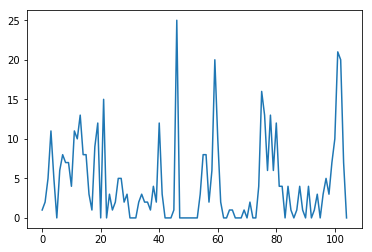

In [250]:
plt.plot(range(n_series), serie)
plt.show()

In [191]:
x = np.random.uniform(-5,5,1000)
x.sort()

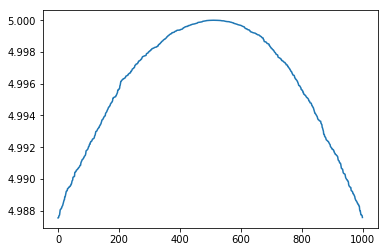

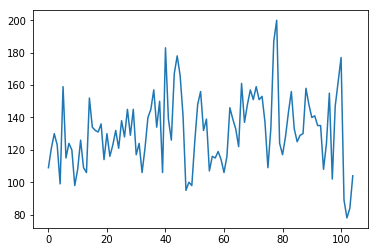

In [256]:
plt.plot(5*(np.e**(-(x/100)**2)))
plt.show()
plt.plot(range(n_series), serie)
plt.show()

In [242]:
suma = sum(serie)

In [243]:
a = []
for i in serie:
    a.append(i/float(suma))

In [244]:
a

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0021691973969631237,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0021691973969631237,
 0.0021691973969631237,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0021691973969631237,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0021691973969631237,
 0.0021691973969631237,
 0.0021691973969631237,
 0.0,
 0.0,
 0.0,
 0.0021691973969631237,
 0.0,
 0.0021691973969631237,
 0.0021691973969631237,
 0.0,
 0.004338394793926247,
 0.0021691973969631237,
 0.004338394793926247,
 0.0,
 0.0021691973969631237,
 0.0,
 0.0,
 0.004338394793926247,
 0.0,
 0.0021691973969631237,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0021691973969631237,
 0.0,
 0.0021691973969631237,
 0.0,
 0.0,
 0.0021691973969631237,
 0.0021691973969631

## La suma da picos

In [121]:
def serie_apariciones(word,origin_united_text):
    apariciones=[]
    for i in origin_united_text:
        if(word==i):
            apariciones.append(1)
        else:
            apariciones.append(0)
    return apariciones

In [122]:
def g(t, mu, sigma):
    return (1 / np.sqrt(2*np.pi*sigma**2)) * (np.exp(-(t-mu)**2/(2*sigma**2)))

In [123]:
xs = [1 * x for x in range(1,len(origin_united_text))]
res = [0*len(xs)]

In [177]:
x = [x * 0.5 for x in range(-25,25)]
y = [g(xi, 0, 50) for xi in x]

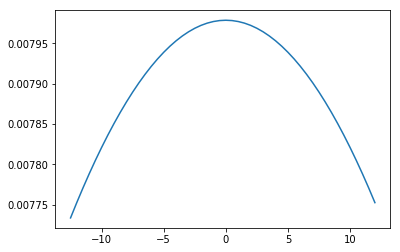

In [178]:
plt.plot(x,y)
plt.show()

In [205]:
## Acá no pasó nada

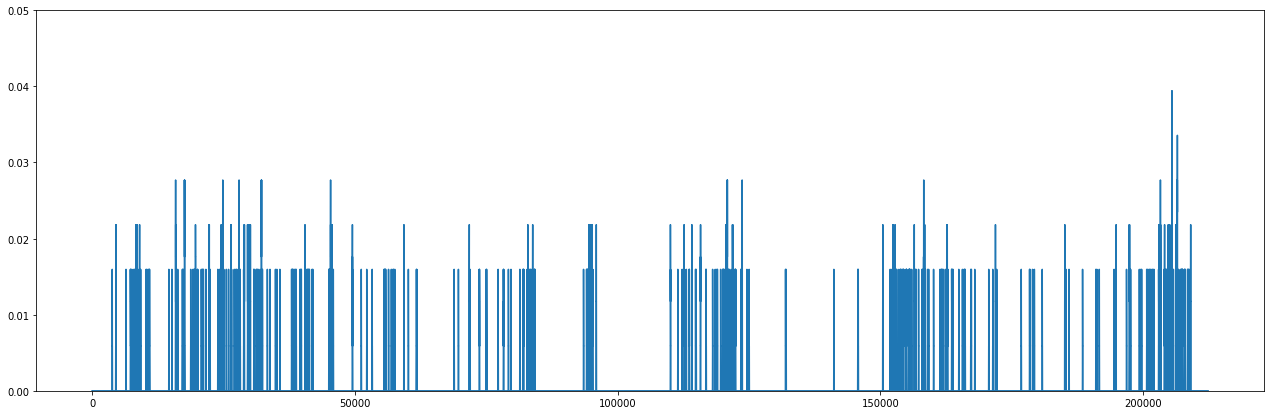

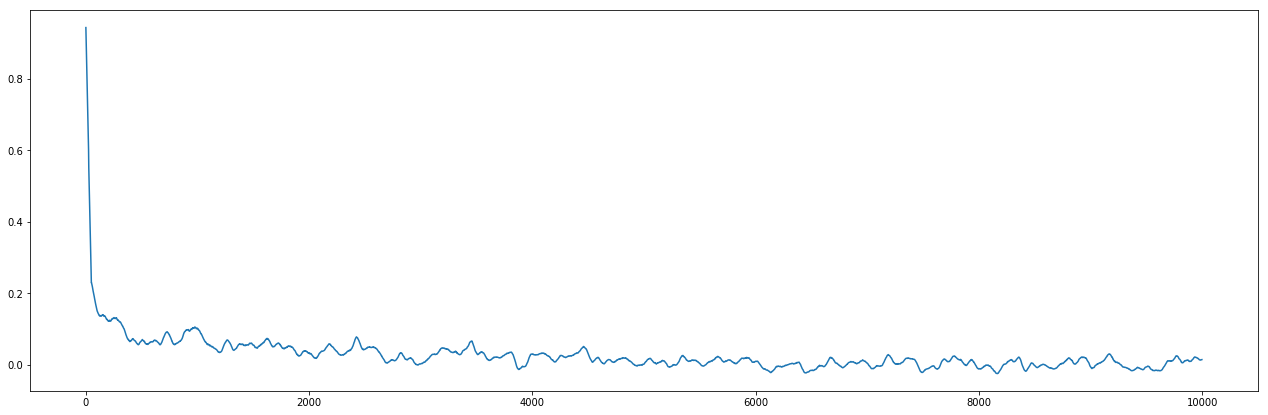

In [224]:
autocorrelation_fun('plants')

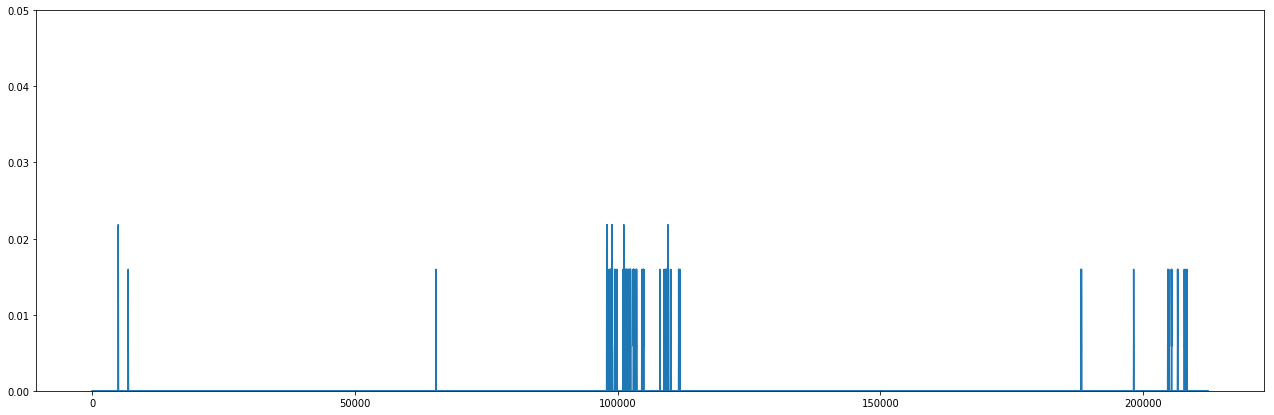

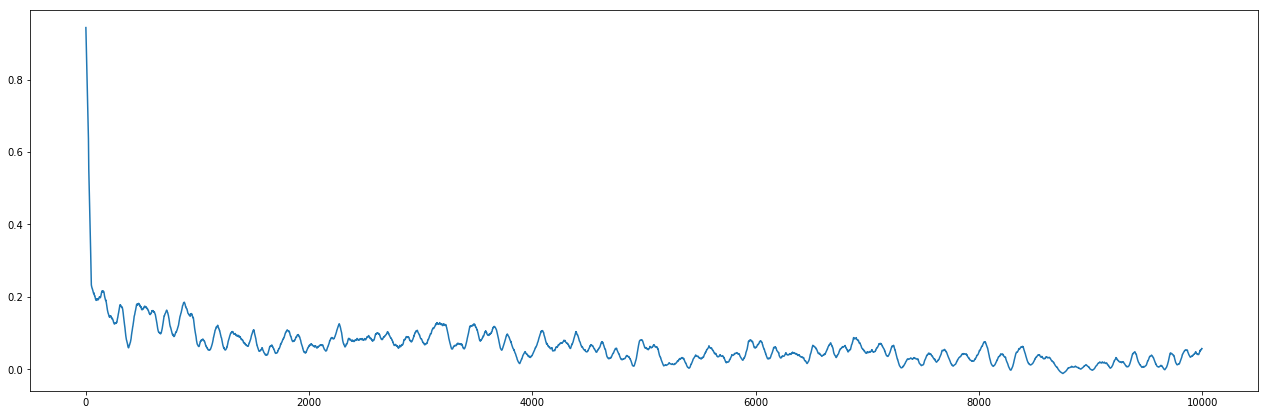

In [223]:
autocorrelation_fun('instinct')

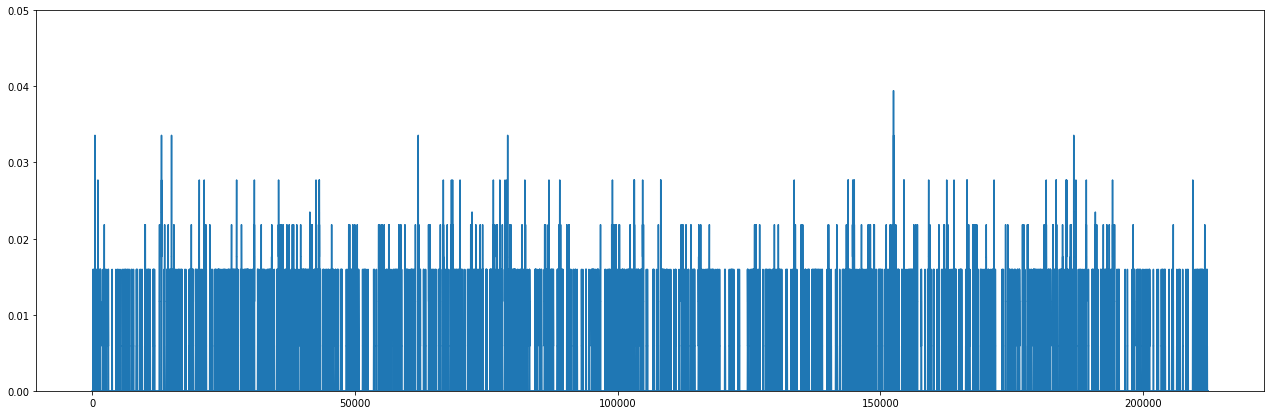

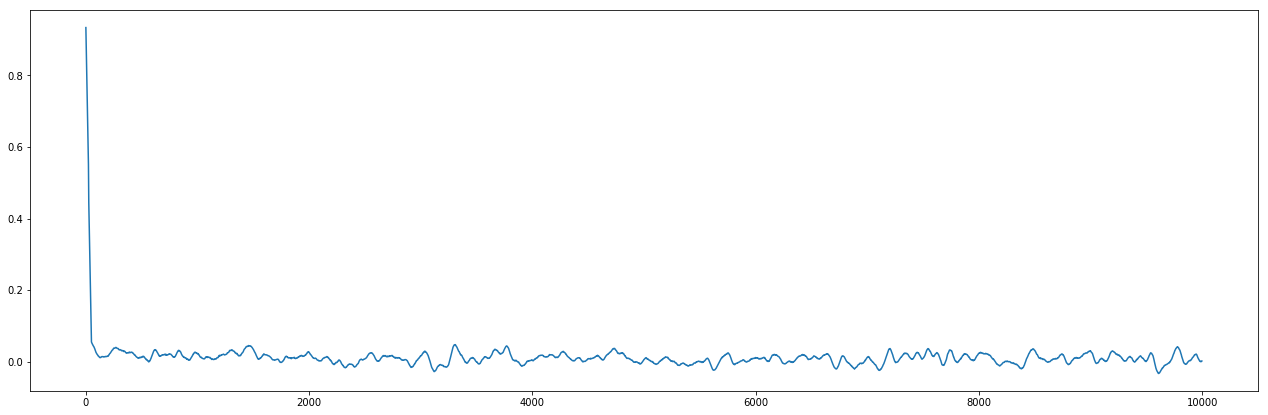

In [222]:
autocorrelation_fun('for')


In [221]:
def autocorrelation_fun(word):
    serie=serie_apariciones(word,origin_united_text)
    res = [0] * len(xs)
    x = [x for x in range(-25,25)]
    y = [g(xi, 0, 25) for xi in x]

    for i in range(1,len(origin_united_text)):
        if(serie[i]==1):
            if(i-25<0):
                4
            #    for j in range(i-1,-1,-1):
            #        res[j] += y[25-j]
            #    print "nada"
            elif(i+25>len(origin_united_text)):
                4
            #    problemas
            #    print "nada"
            else:
                for j in range(0,50):
                    res[i+j-25] = res[i+j-25] + y[j]

    plt.figure(figsize= (22,7))
    plt.plot(res)
    plt.ylim(0, 0.05)
    plt.show()

    serie_autocorr = pd.Series(res)
    plt.figure(figsize= (22,7))
    plt.plot([serie_autocorr.autocorr(lag=x) for x in range(1,10000)])
    plt.show()

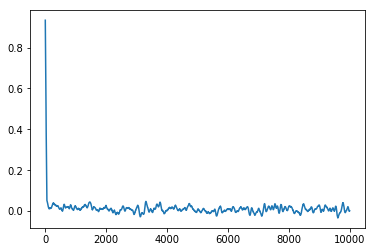

In [216]:
plt.show()

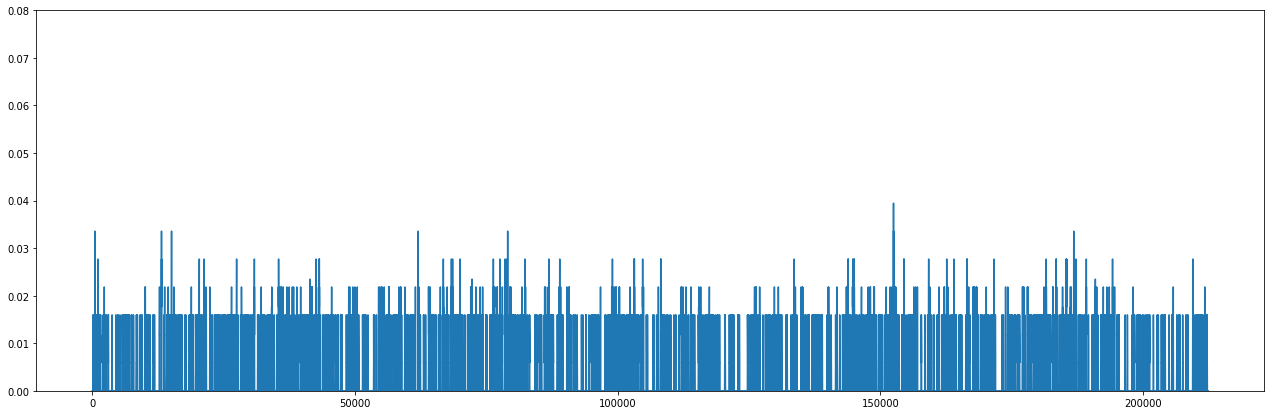

In [204]:
plt.figure(figsize= (22,7))
plt.plot(res)
plt.ylim(0, 0.08)

plt.show()

## Autocorrelation

## c

In [ ]:
general_dicc=[]

for i in range(len(texts)):
    general_dicc.append(Counter(texts[i]))

zeros = [0] * len(vocab)

frecuency_dict = dict(zip(vocab, zeros))

for i in range(len(texts)):
    for word in general_dicc[i].keys():
        if word in frecuency_dict.keys():
            frecuency_dict[word] += general_dicc[i][word]

sorted_frecuency = sorted(frecuency_dict.items(), key=operator.itemgetter(1))
dicc_selected = dict(sorted_frecuency[-500:])